# Boilerplate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rpy2.robjects as rob
import seaborn as sns
from datetime import datetime
import os
import pickle
from scipy.special import logit
from tqdm import tqdm
import re
from itertools import islice
from collections import defaultdict
td = pd.datetools.timedelta
import networkx

INTRADE_PATH = '/home/jai/Intrade-Contracts-NoFinancial/'

## GetData Functions

### Utility Functions

In [2]:
def hey(msg='hey'):
    def f(x):
        print msg
        return x
    return f

def mgroup(t):
    return t.groupby('market_id')

def logloss(p, result):
    """Get logloss from (p)rob and result==0 (no) or ==1 (yes)"""
    return  np.log((p - (result==0)).abs())

### Import CSVs

In [3]:
def read_trade_times(times):
    return [datetime.strptime(t, '%b/%d/%Y %H:%M:%S') for t in times]

def colname_fix(df):
    print 'Fixing column names...'
    columns = map(lambda x: re.sub(r'[\[\/\]]', '', x), df.columns)
    columns = map(lambda x: '_'.join(x.split(' ')), columns)
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    return df

def tradescsv_or_nothing(csv_path, intrade_path=INTRADE_PATH):
    try:
        df = pd.read_csv(csv_path, parse_dates=[5], date_parser=read_trade_times)
        category = csv_path.split(intrade_path)[1].split('/')[0]
        df['category'] = category
        return df
    except ValueError:
        return None
    
def get_trade_paths(intrade_path):
    trades=[]
    for dp, dn, fns in os.walk(intrade_path):
        sumfns = filter(lambda x: x.endswith('trades.csv'), fns)
        trades += map(lambda x: os.path.join(dp, x), sumfns)
    return trades

def read_trade_csvs(intrade_path):
    print 'Reading trade csvs...'
    readcsv = lambda csv_path: tradescsv_or_nothing(csv_path, intrade_path)
    return colname_fix(pd.concat(hey('Concatenating dfs...')(map(
                readcsv, 
                tqdm(get_trade_paths(intrade_path))
            ))))

def remove_weird_markets(trades):
    weird_mkts = \
        r'ELECTORALVOTES$|\-OPENING\.WEEKEND$|^LIV-EX100\.|^MEI.MOSES|^TOTAL.SEATS.|^ELEC.COL.VOTES'
    trades = trades[~trades.market_symbol.str.contains(weird_mkts)]
    trades = trades[~trades.market_id.isin((650479, 673548))]
    return trades.copy()

def get_trades(path=INTRADE_PATH, trades=None, tradesfname=None):
    if tradesfname is not None:
        print 'loading raw trading data from pickle...',
        trades = pload(tradesfname)
    else:
        trades = trades or read_trade_csvs(path)
    trades = trades[~trades.trade_price.isnull()].copy()
    trades = remove_weird_markets(trades)
    alls = (lambda t=None: slice(None))
    assignments = [
        (alls, 'market_symbol', lambda t: t.market_symbol.astype('category')),
        (alls, 'market_name', lambda t: t.market_name.astype('category')),
        (alls, 'p', lambda t: t.trade_price/100.),
        (alls, 'final_time', lambda t: mgroup(t).datetime_utc.transform('max')),
        (alls, 'final_p', lambda t: mgroup(t).p.transform('last')),
        (alls, 'countdown', lambda t: t.datetime_utc - t.final_time),
        (alls, 'hours', lambda t: np.round(t.countdown.dt.total_seconds()/3600., 0)),
        (alls, 'days', lambda t: np.round(t.countdown.dt.total_seconds()/86400., 0)),
        (alls, 'result', lambda t: np.full(t.shape[0], np.nan)),
        (lambda t: t.final_p>=0.95, 'result', lambda t: 1),
        (lambda t: t.final_p<=0.05, 'result', lambda t: 0),
        (alls, 'year', lambda t: t.datetime_utc.dt.year),
        (alls, 'final_year', lambda t: t.final_time.dt.year),
        (alls, 'start_time', lambda t: mgroup(t).datetime_utc.transform('min')),
        (alls, 'duration', lambda t: t.final_time - t.start_time),
        (alls, 'lodds', lambda t: np.log(t.p/(1.0 - t.p))),
    ]
    print ' * sorting by datetime * '
    trades.sort_values('datetime_utc', inplace=True)
    trades.set_index('datetime_utc', inplace=True, drop=False)
    print 'Adding columns...',
    for rowf, col, getvals in assignments:
        print col,
        trades.loc[rowf(trades), col] = getvals(trades.loc[rowf(trades), :])
    return trades.copy()

def get_market_info(trades):
    mt = mgroup(trades)
    market_info = mt.last()[[
        'market_symbol', 
        'market_name', 
        'category', 
        'final_time', 
        'start_time', 
        'final_p', 
        'duration',
        'final_year',
        'result'
    ]]
    market_info['total_volume'] = mt.trade_quantity.sum()
    market_info['num_trades'] = mt.market_id.count()
    return market_info

### Resampling

In [4]:
def rs_sum_zero(data, ts='D'):
    """Resample data by sum, fill upsamples with 0"""
    return data.resample(ts, how='sum').fillna(0)


def get_last_per_market(trades, index='datetime_utc'):
    lasts = mgroup(trades).last().reset_index()
    lasts.set_index(index, inplace=True, drop=False)
    return lasts.copy()

def fill_from_prev(trades, prev_trades, index='datetime_utc'):
    lasts = get_last_per_market(prev_trades, index)[trades.columns]
    return pd.concat((trades, lasts))

def resample_trades(trades, ts='D', prev_trades=None, index='datetime_utc'):
    """Resample trades at some time frequency (default: calendar day)
    """
    trades = trades[['market_id', 'p', 'trade_quantity', index]].copy()
    if prev_trades is not None:
        trades = fill_from_prev(trades, prev_trades, index)
    mtrades = mgroup(trades)
    vol = mtrades.trade_quantity.resample(ts, how='sum').fillna(0)
    ps = mtrades.p.resample(ts, how='last', fill_method='ffill')
    numtrades = mtrades.market_id.resample(ts, how='count').fillna(0)
    return pd.DataFrame({
            'volume': vol,
            'p': ps,
            'num_trades': numtrades
        }).reset_index('market_id')
    

def floor_hour(times):
    c = times.dt.components
    tshift = c.minutes.apply(lambda x: td(minutes=x)) + c.seconds.apply(lambda x: td(seconds=x))
    return times - tshift

def align_first_countdown(trades):
    """Align first countdown to be an even number of hours before 0"""
    starts = mgroup(trades).datetime_utc.transform('min')
    firsttrades = (trades.datetime_utc == starts)
    cds = trades.loc[firsttrades, 'countdown']
    trades.loc[firsttrades, 'countdown'] = floor_hour(cds)
    return trades
    
def countdown_to_index(trades):
    trades.set_index('countdown', inplace=True, drop=False)
    return trades

def resample_trades_countdown(trades, prev_trades=None, cutoff=None):
    trades=trades.copy()
    if prev_trades is not None:
        prev_trades = get_last_per_market(prev_trades)
        countdowns = prev_trades.loc[:, 'countdown']
        prev_trades.loc[:, 'countdown'] = floor_hour(countdowns)
        prev_trades = countdown_to_index(prev_trades)
    else:
        trades = align_first_countdown(trades)
    trades = countdown_to_index(trades)
    resamples = resample_trades(trades, 'H', prev_trades, index='countdown')
    if cutoff:
        resamples = resamples.loc[resamples.index >= cutoff, :]
    return resamples.reset_index()

def get_trade_days(trades, market_info):
    tradedays = resample_trades(trades[~trades.result.isnull()])
    tradedays = tradedays.merge(market_info, left_on='market_id', right_index=True)
    tradedays['log_loss'] = np.nan
    tradedays.loc[tradedays.result==1, 'log_loss'] = np.log(tradedays.loc[tradedays.result==1, 'p'])
    tradedays.loc[tradedays.result==0, 'log_loss'] = np.log(1. - tradedays.loc[tradedays.result==0, 'p'])
    tradedays['date'] = tradedays.index
    return tradedays

## Get Data

In [186]:
#trades = get_trades()
trades = get_trades(tradesfname='raw_trades')

loading raw trading data from pickle...  * sorting by datetime * 
Adding columns... market_symbol market_name p final_time final_p countdown hours days result result result year final_year start_time duration lodds


In [189]:
market_info = get_market_info(trades)

In [194]:
tradedays = get_trade_days(trades, market_info)

In [15]:
def get_finaldays(trades, days=60):
    tfilter = (trades.duration > td(days=days))
    postfilter = (trades.countdown > -td(days=days))
    prefilter = ~postfilter
    last60 = trades[tfilter & postfilter]
    pre60 = trades[tfilter & prefilter]

    final60 = resample_trades_countdown(last60, pre60, -td(days=days))
    final60 = final60.merge(market_info, left_on='market_id', right_index=True)
    final60 = final60[~final60.result.isnull()]
    final60['logloss'] = logloss(final60.p, final60.result)
    return final60

In [16]:
final60 = get_finaldays(trades, 60)

## Pickle

In [5]:
def ppath(name, base=INTRADE_PATH):
    return os.path.join(base, name + '.pickle')

def pdump(thing, name):
    with open(ppath(name), 'w+') as f:
        pickle.dump(thing, f, pickle.HIGHEST_PROTOCOL)

def pload(name):
    with open(ppath(name)) as f:
        x = pickle.load(f)
    return x

In [190]:
pdump(trades, 'trades')

In [193]:
pdump(market_info, 'market_info')

In [ ]:
pdump(raw_trades, 'raw_trades')

In [195]:
pdump(tradedays, 'tradedays')

In [23]:
pdump(final60, 'final60')

### Load Data From Pickles

In [6]:
trades = pload('trades')
market_info = pload('market_info')
tradedays = pload('tradedays')
final60 = pload('final60')

## Colormaps

In [7]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    np.logspace
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
cmap = sns.diverging_palette(h_neg=15, h_pos=255, s=99, l=35, sep=1, n=15, as_cmap=True)
scmap = shiftedColorMap(cmap, start=0.0, midpoint=0.33, stop=1.0)

# Analysis

## Example: GOP 2008 Nominee

<IPython.core.display.Javascript object>


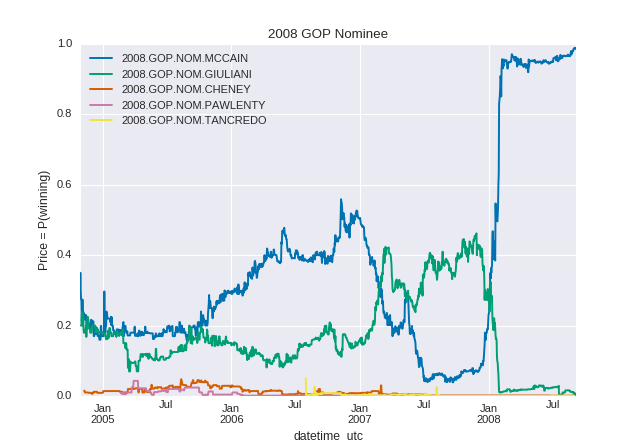

In [235]:
%matplotlib notebook

markets = [m for m in tradedays.market_symbol.unique() if m.startswith('2008.GOP.NOM')]
ax = plt.gca()
colors = sns.color_palette('colorblind', n_colors=5)
for m in markets:
    vals = tradedays[tradedays.market_symbol==m].p
    if vals.max() > 0.04:
        vals.plot(ax=ax, label=m, color=colors.pop(0))
ax.set_title('2008 GOP Nominee')
ax.legend(loc='upper left');
ax.set_ylabel('Price = P(winning)');

## Categories

<IPython.core.display.Javascript object>


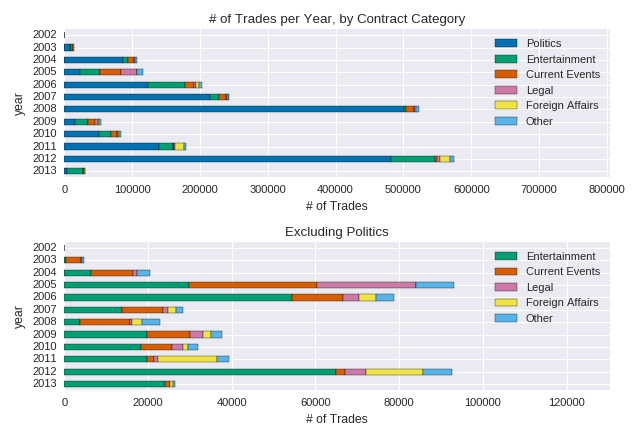

In [164]:
%matplotlib notebook

sns.set()

ncats = 5

color = sns.color_palette('colorblind', n_colors=(ncats+1))

f, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
catcounts = trades.groupby('category').market_id.count().sort_values(ascending=False)
bigcats = catcounts.index[:ncats]
smallcats = catcounts.index[ncats:]
catyears=trades.groupby(['year', 'category']).market_id.count().unstack('category')
smallcatcounts = catyears[smallcats].sum(axis=1)
catyears = catyears[bigcats]
catyears['Other'] = smallcatcounts
catyears.fillna(0, inplace=True)
catyears.sort_index(inplace=True, ascending=False)
ax1.grid(True)
catyears.plot.barh(stacked=True, color=color, ax=ax1)
ax1.legend(loc='upper right')
ax1.set_title('# of Trades per Year, by Contract Category')
ax1.set_xlim(0, max(catyears.sum(axis=1))*1.4)
ax1.set_xlabel('# of Trades')


othercats = filter(lambda cat: 'politics' not in cat.lower(), catyears.columns)
catyearsnp = catyears.loc[:, othercats]
catyearsnp.plot.barh(stacked=True, color=color[1:], ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Excluding Politics');
ax2.set_xlim(0, max(catyearsnp.sum(axis=1))*1.4)
ax2.set_xlabel('# of Trades')
f.tight_layout()

## Active Markets Over Time

<IPython.core.display.Javascript object>


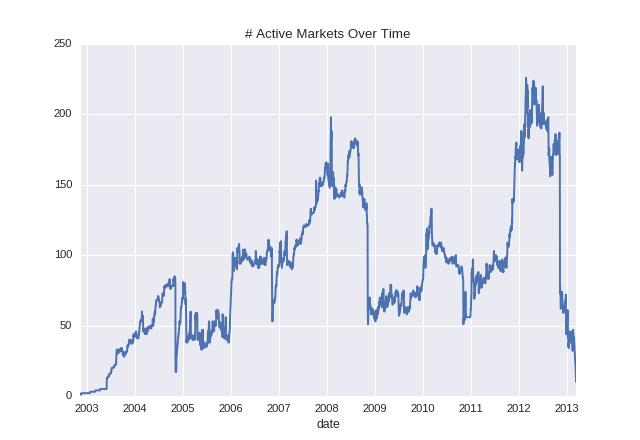

In [80]:
%matplotlib notebook
tradedays.groupby('date').market_id.count().plot()
plt.title('# Active Markets Over Time');

## Performance

### Log Loss - Last 60 Days

In [46]:
tfilter = (trades.duration > td(days=60))
postfilter = (trades.countdown > -td(days=60))
prefilter = ~postfilter
last60 = trades[tfilter & postfilter]
pre60 = trades[tfilter & prefilter]

final60 = resample_trades_countdown(last60, pre60, -td(days=60))
final60 = final60.merge(market_info, left_on='market_id', right_index=True)
final60 = final60[~final60.result.isnull()]
final60['logloss'] = logloss(final60.p, final60.result)

<IPython.core.display.Javascript object>


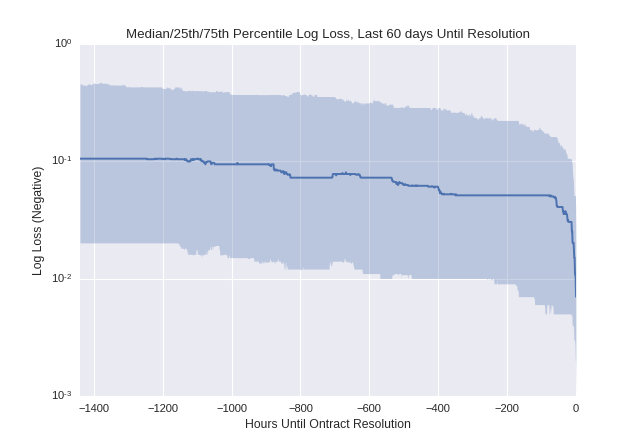

In [79]:
%matplotlib notebook
bycd = final60.groupby('countdown')
ll = bycd.logloss.median()
hours = ll.index.total_seconds()/3600
ll50 = -ll.values
ll25 = -bycd.logloss.quantile(0.25)
ll75 = -bycd.logloss.quantile(0.75)
plt.plot(hours, ll50)
plt.fill_between(hours, ll25, ll75, alpha=0.3, linewidth=0.0)
plt.yscale('log');
plt.xlim(hours.min(), hours.max())
plt.title('Median/25th/75th Percentile Log Loss, Last 60 days Until Resolution')
plt.xlabel('Hours Until Ontract Resolution')
plt.ylabel('Log Loss (Negative)');

#### By Year

In [86]:
yearlyll = {}
for y in xrange(2004, 2013):
    ll = dict()
    data = final60[final60.final_year==y]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['05'] = -hb.logloss.quantile(0.05)
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    ll['95'] = -hb.logloss.quantile(0.95)
    yearlyll[y] = ll

<IPython.core.display.Javascript object>


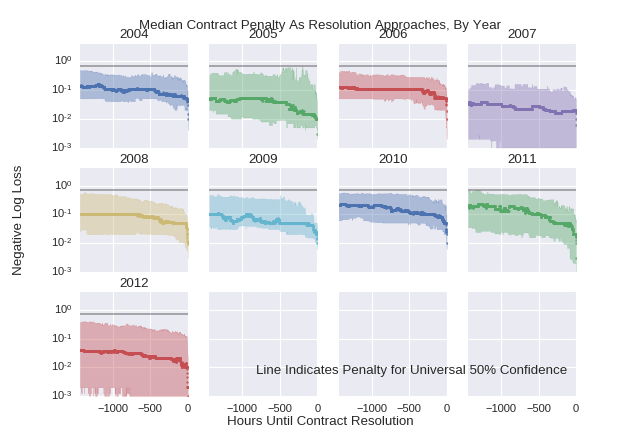

In [101]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(3, 4, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, y in zip(axes, yearlyll.iteritems()):
    color = palette.pop(0)
    year, ll = y
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=year, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(int(year))
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Year', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')
fig.text(0.4, 0.15, 'Line Indicates Penalty for Universal 50% Confidence');

#### By Category

In [89]:
catll = {}
cats = ('Politics', 'Entertainment', 'Current Events', 'Legal', 'Foreign Affairs')
for c in cats:
    ll = dict()
    data = final60[final60.category==c]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['05'] = -hb.logloss.quantile(0.05)
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    ll['95'] = -hb.logloss.quantile(0.95)
    catll[c] = ll

<IPython.core.display.Javascript object>


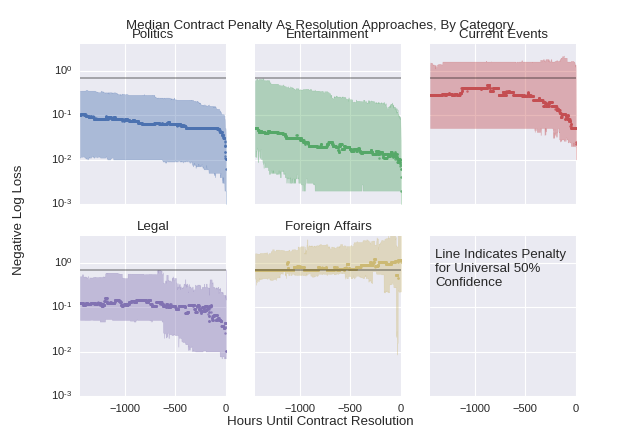

In [99]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(2, 3, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, cat in zip(axes, cats):
    color = palette.pop(0)
    ll = catll[cat]
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=cat, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(cat)
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Category', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical');
fig.text(0.68, 0.35, 'Line Indicates Penalty\nfor Universal 50% \nConfidence');

### Daily Log Loss (All time, All contracts)

In [8]:
daygrp = tradedays.groupby('date')
volume = daygrp.trade_quantity.sum()
log_loss = -daygrp.log_loss.median()
vlowlog_loss = -daygrp.log_loss.quantile(0.05)
lowlog_loss = -daygrp.log_loss.quantile(0.25)
highlog_loss = -daygrp.log_loss.quantile(0.75)
vhighlog_loss = -daygrp.log_loss.quantile(0.95)

AttributeError: 'DataFrameGroupBy' object has no attribute 'trade_quantity'

<IPython.core.display.Javascript object>


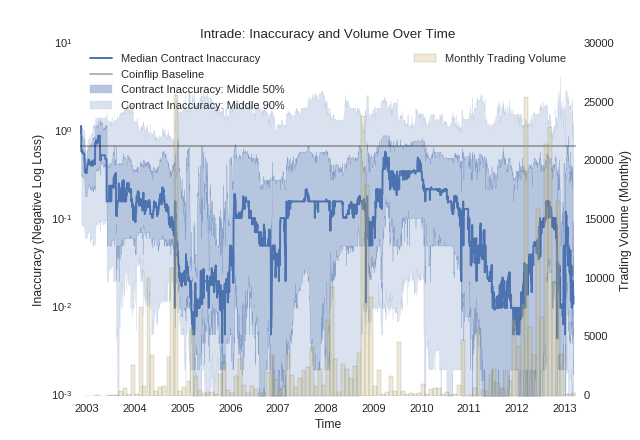

In [83]:
%matplotlib notebook
mvolume = volume.asfreq('M')
sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

colors = sns.color_palette()
colora = colors[0]
colorb = colors[4]

ax = plt.gca()
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
dates=log_loss.index
ax.set_yscale('log')

ax2.bar(mvolume.index, mvolume.values, color=colorb, width=30, alpha=0.3, label='Monthly Trading Volume')
ax.plot(log_loss.index, log_loss.values, '-', label='Median Contract Inaccuracy', color=colora)
ax.fill_between(dates, lowlog_loss, highlog_loss, alpha=.4, color=colora, label='Contract Inaccuracy: Middle 50%')
ax.fill_between(dates, vlowlog_loss, lowlog_loss, alpha=.2, color=colora, label='Contract Inaccuracy: Middle 90%')
ax.fill_between(dates, highlog_loss, vhighlog_loss, alpha=.2, color=colora)



ax.set_xlabel('Time')
ax.set_ylabel('Inaccuracy (Negative Log Loss)')
ax2.set_ylabel('Trading Volume (Monthly)')
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Intrade: Inaccuracy and Volume Over Time");

## Intrade <3 5

<IPython.core.display.Javascript object>


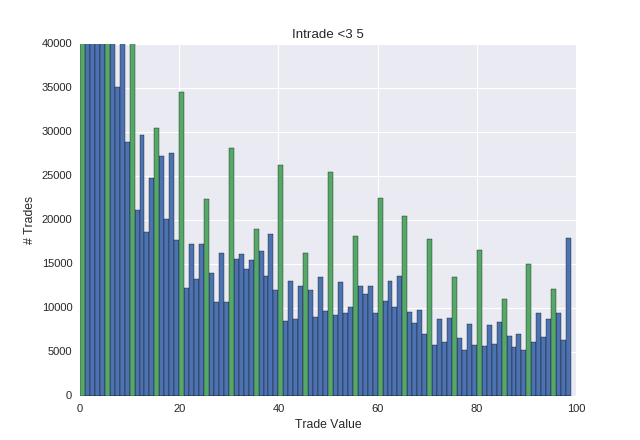

In [50]:
%matplotlib notebook
ax = plt.gca()
roundt = (100*trades.p).round(0)
roundt[roundt%5!=0].hist(bins=np.arange(100), ax=ax)
roundt[roundt%5==0].hist(bins=np.arange(100), ax=ax)
ax.set_ylim(0, 40000)
ax.set_title('Intrade <3 5')
ax.set_xlabel('Trade Value')
ax.set_ylabel('# Trades')

## Return on Investment

In [33]:
roidata = final60.loc[:, ['p', 'countdown', 'result', 'market_id']]
roidata['price'] = np.round(roidata.p*10, 0)*10
roidata['day'] = roidata.countdown.dt.days
roidata['roi'] = roidata.result / roidata.p

In [38]:
roidata = roidata.merge(market_info, left_on='market_id', right_index=True)

In [39]:
pdump(roidata, 'roidata')

In [49]:
def roiheatmap(roidata, ax=None):
    ax = ax or plt.gca()
    binned = roidata.groupby(['price', 'day']).roi.mean().reset_index()
    pivoted = binned.pivot(index='price', columns='day', values='roi')
    ax.set_title('Expected ROI on Intrade Contracts')
    ax.set_xlabel('Days Until Contract Resolution')
    return sns.heatmap(pivoted, cmap=cmap, center=1.0, xticklabels=5, ax=ax);

### ROI vs (price, time until resolution)

<IPython.core.display.Javascript object>


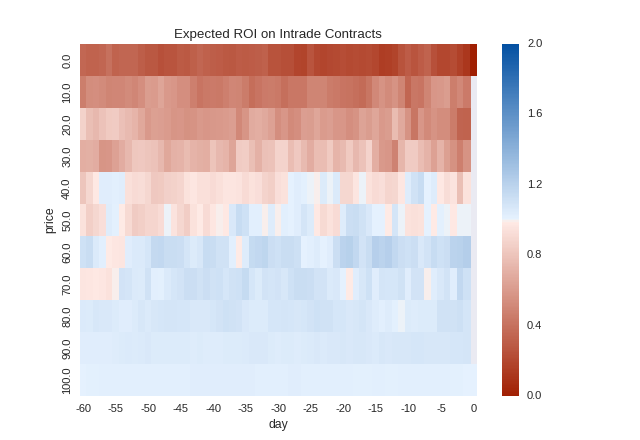

In [53]:
%matplotlib notebook
roiheatmap(roidata);

### ROI: Politics, Everything Else

In [55]:
roidata[roidata.category=='Politics'].market_id.nunique()

1584

<IPython.core.display.Javascript object>


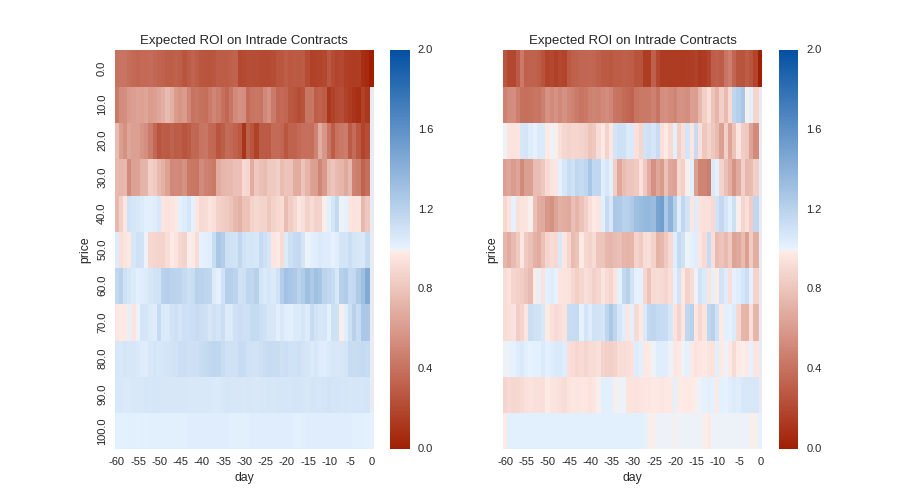

In [54]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
roiheatmap(roidata[roidata.category=='Politics'], ax1)
roiheatmap(roidata[roidata.category!='Politics'], ax2)

## Market Correlation

In [9]:
tradedays['lodds'] = np.log(tradedays.p/(1.0-tradedays.p))
yesterlodds = tradedays.lodds.shift(1)
tradedays['loddsdiff'] = tradedays.lodds - yesterlodds
start_days = (tradedays.start_time.dt.date == tradedays.date.dt.date).values
tradedays.loc[start_days, 'loddsdiff'] = 0

In [10]:
interesting_tradedays = tradedays[tradedays.total_volume>100]
all_lods=interesting_tradedays.pivot(index='date', columns='market_id', values='loddsdiff')
all_lods[all_lods==0.0] = np.nan

In [11]:
corrs=all_lods.corr(min_periods=30)

In [15]:
uc=pd.DataFrame(corrs.unstack())
uc=uc.reset_index(0).rename(columns={'market_id': 'm1'}).reset_index().rename(columns={'market_id': 'm2'})
uc.rename(columns={0:'correlation'}, inplace=True)
uc.loc[uc.m1==uc.m2, 'correlation'] = np.nan
uc = uc[~uc.correlation.isnull()].copy()
uc['abscorrelation'] = uc.correlation.abs()
uc = uc.sort_values('abscorrelation', ascending=False)
mid_name = pd.DataFrame(market_info.market_symbol)
mid_cat = pd.DataFrame(market_info.category)
uc = uc.merge(mid_name, left_on='m1', right_index=True).rename(columns={'market_symbol': 'm1_name'})
uc = uc.merge(mid_name, left_on='m2', right_index=True).rename(columns={'market_symbol': 'm2_name'})
uc = uc.merge(mid_cat, left_on='m1', right_index=True).rename(columns={'category': 'm1_category'})
uc = uc.merge(mid_cat, left_on='m2', right_index=True).rename(columns={'category': 'm2_category'})

In [19]:
pdump(uc, 'market_correlation')

In [23]:
uc[(uc.m1_category!='Politics') & (uc.m2_category!='Politics')].sort_values('abscorrelation', ascending=False).iloc[100:150,:]

,m2,m1,correlation,abscorrelation,m1_name,m2_name,m1_category,m2_category
4162358,315507,315554,-0.694093,0.694093,PICTURE.GOODNIGHT,ACTOR.HOFFMAN,Entertainment,Entertainment
4106822,315554,315507,-0.694093,0.694093,ACTOR.HOFFMAN,PICTURE.GOODNIGHT,Entertainment,Entertainment
13107529,705993,705994,0.685396,0.685396,TIGER.PLAYS.MAY10,TIGER.PLAYS.APR10,Current Events,Current Events
13102901,705994,705993,0.685396,0.685396,TIGER.PLAYS.APR10,TIGER.PLAYS.MAY10,Current Events,Current Events
7430806,392675,464823,0.667371,0.667371,GONZALES.RESIGN.SEP07,OSAMA.CAPTURE.DEC07,Current Events,Current Events
5838774,464823,392675,0.667371,0.667371,OSAMA.CAPTURE.DEC07,GONZALES.RESIGN.SEP07,Current Events,Current Events
7185768,454336,450466,-0.664835,0.664835,AI.FEMALE,AI.BLAKE,Entertainment,Entertainment
7222792,450466,454336,-0.664835,0.664835,AI.BLAKE,AI.FEMALE,Entertainment,Entertainment
13542751,716708,716707,0.663796,0.663796,AIRSTRIKE.IRAN.SEP11,AIRSTRIKE.IRAN.DEC11,Foreign Affairs,Foreign Affairs
13547379,716707,716708,0.663796,0.663796,AIRSTRIKE.IRAN.DEC11,AIRSTRIKE.IRAN.SEP11,Foreign Affairs,Foreign Affairs


In [103]:
uc.loc[uc.abscorrelation>0.3,['m1_name', 'm2_name']].stack().nunique()

929

In [92]:
all_lods.loc[~all_lods[178522].isnull(), 178522].values

array([-1.65068087, -1.21101863, -0.40646761,  0.6951532 , -0.6951532 ,
        0.6951532 , -0.6951532 , -0.69414868,  1.38930188, -1.38930188,
        1.1006163 , -1.1006163 ,  1.1006163 , -1.1006163 ,  0.69414868,
       -0.69414868,  0.69414868, -0.69414868,  1.95193426, -1.95193426,
        0.69414868, -0.69414868,  1.1006163 , -1.1006163 ,  2.31163493,
       -2.31163493,  0.69414868, -0.69414868])

In [144]:
market_info.loc[pd.Series(corrs).sort_values()[:10].index, 'market_name'].values

array([ "Republican Party Nominee to win Ohio's Electoral College Votes in 2008 Election",
       'Republican Nominee to win 250 or more Electoral College Votes',
       'Republican Nominee to win 240 or more Electoral College Votes',
       'Increase in US Government debt if non-Democrat is elected president in 2008',
       'Republican Nominee to win 220 or more Electoral College Votes',
       'Republican Nominee to win 210 or more Electoral College Votes',
       "Republican Party Nominee to win Florida's Electoral College Votes in 2008 Election",
       "Republican Party Nominee to win Nevada's Electoral College Votes in 2008 Election",
       'Democratic Nominee to win 380 or more Electoral College Votes',
       'Number of US troops in Iraq on 30 June 2010 if a non-Democrat is elected president in 2008'], dtype=object)

In [145]:
market_info.loc[pd.Series(corrs).sort_values()[-10:].index, 'market_name'].values

array([ 'USA and/or Israel to execute an overt Air Strike against Iran by 30 Jun 2009',
       'USA and/or Israel to execute an overt Air Strike against Iran by 30 Sep 2009',
       'USA and/or Israel to execute an overt Air Strike against Iran by 31 Dec 2009',
       'Average national price for regular unleaded gas to be $2.50 per gallon or more on 31 Oct 08',
       'Average national price for regular unleaded gas to be $2.75 per gallon or more on 31 Oct 08',
       'Republican Party candidate to win 2012 Presidential Election',
       'Hillary Clinton to be on Democratic ticket on 2008 Election Day',
       'The Dark Knight to Win the Oscar',
       'The 2008 US Presidential Election to be Postponed',
       'Osama Bin Laden to be captured/neutralised by 30 Jun 2009'], dtype=object)

# Unorganized / Broken / Abandoned

In [185]:
election_years = (2008, 2012)
off_years = (2005, 2006, 2007, 2009, 2010, 2011)
yearsets = ((2005, 2006, 2007), (2008,), (2009, 2010, 2011), (2012,))
yearly_trades = map(lambda x: trades[trades.final_year.isin(x)], (election_years, off_years))
custom_tproi = lambda t: trades_to_tproi(t, pricebins=4)
yearly_rois = map(custom_tproi, yearly_trades)
#f, (axes) = plt.get_sub
#f, (ax05, ax08, ax09, ax12) = plt.subplots(4, 1, sharex=True, sharey=False)

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .


<IPython.core.display.Javascript object>


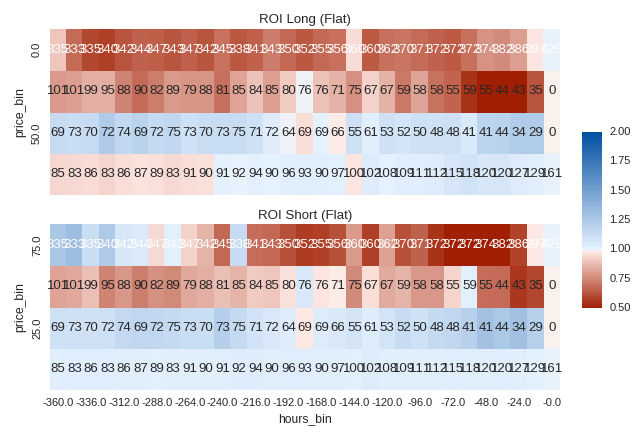

/home/jai/.local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


<IPython.core.display.Javascript object>


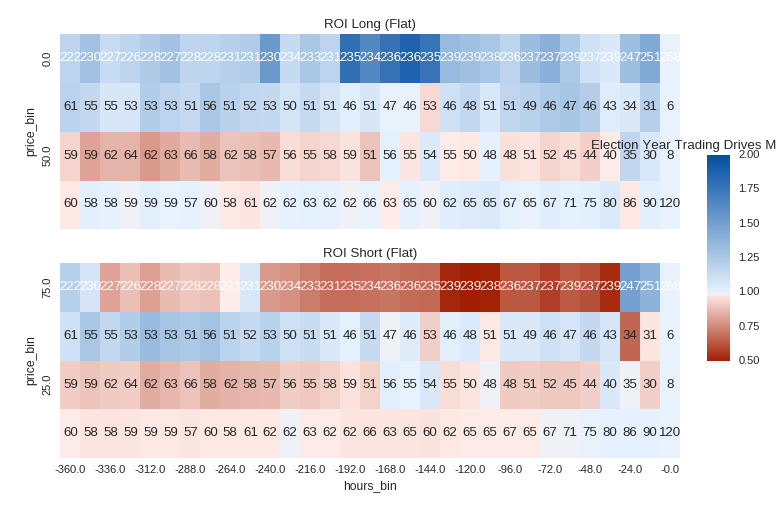

In [186]:
%matplotlib notebook
for roi in yearly_rois:
    plot_rois(roi, samplesize=True)
plt.title('Election Year Trading Drives Miscalibration')

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


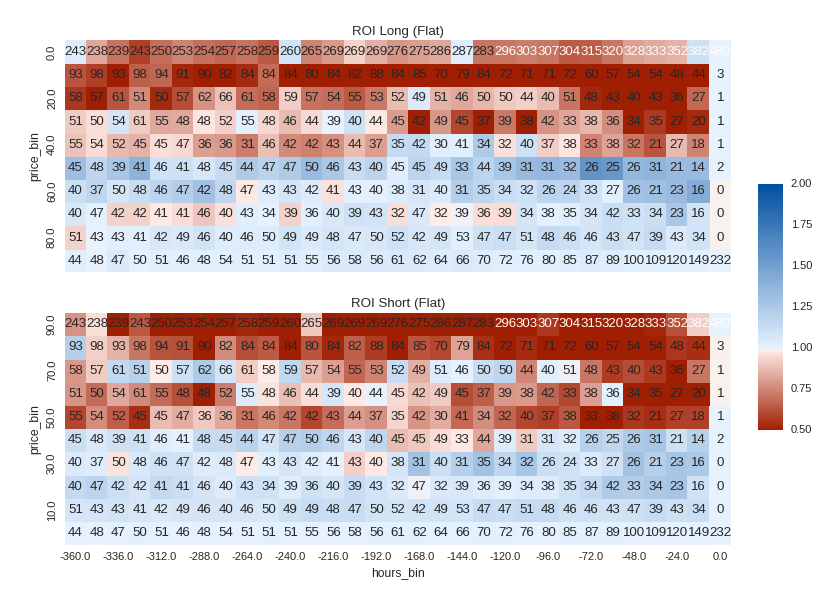

<IPython.core.display.Javascript object>


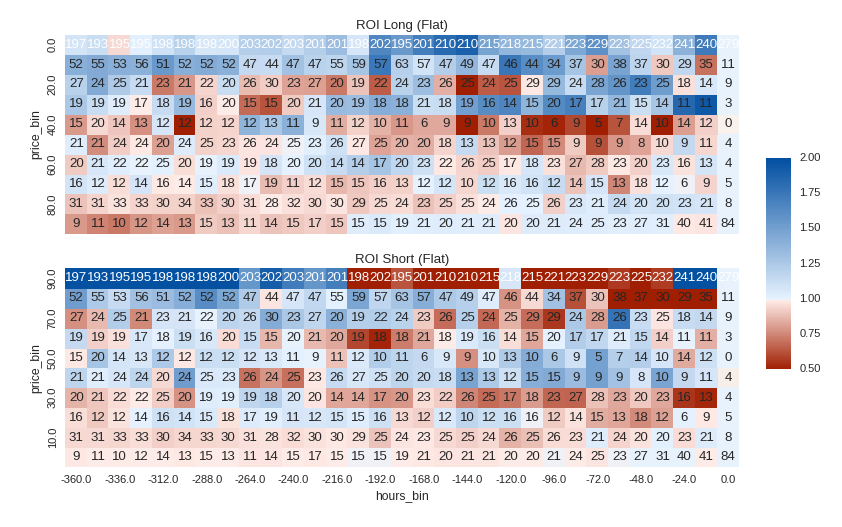

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82b9e28ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b03eb2d0>)

In [187]:
%matplotlib notebook
ptrades = trades[trades.category=='Politics']
nptrades = trades[~(trades.category=='Politics')]
proi, nproi = map(trades_to_tproi, (ptrades, nptrades))
plot_rois(proi, samplesize=True)
plot_rois(nproi, samplesize=True)

{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


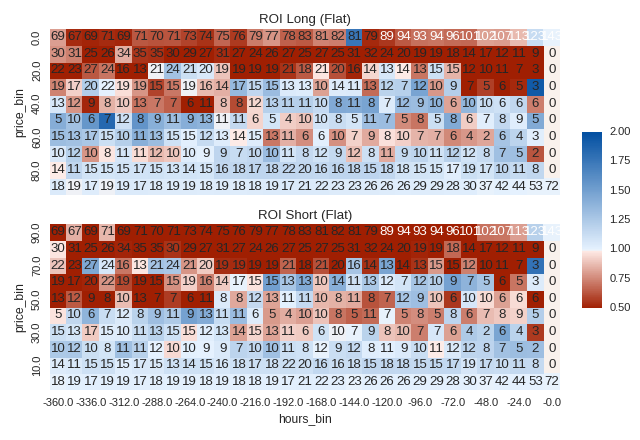

<IPython.core.display.Javascript object>


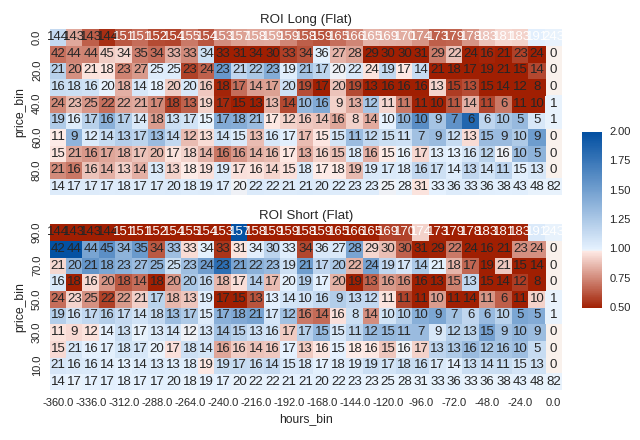

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82c7790fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b8b64f50>)

In [188]:
%matplotlib notebook
ptrades08 = ptrades[ptrades.final_year.isin((2008, 2009))]
ptrades12 = ptrades[ptrades.final_year.isin((2012, 2013))]
roi08, roi12 = map(trades_to_tproi, (ptrades08, ptrades12))
plot_rois(roi08, samplesize=True)
plot_rois(roi12, samplesize=True)

In [189]:
%matplotlib notebook
print '.',
ptrades_us = ptrades[~ptrades.market_symbol.str.contains(r'LIB-?DEMS?\.|EASTLEIGH')]
print '.',
ptrades_us = ptrades_us[~ptrades_us.market_symbol.str.startswith('UK.')]
ptrades_us = ptrades_us[~ptrades_us.market_symbol.str.startswith('LON.')]

print '.',
ptradesd = ptrades_us[ptrades_us.market_name.str.contains(r'Obama|Clinton|Edwards|Democrat|Biden|DNC')]
print '.',
ptradesr = ptrades_us[ptrades_us.market_name.str.contains(r'Bush|McCain|Palin|Romney|Paul|RNC|Republican')]

. . . .


In [272]:
print roid.roi_short.min(), roid.roi_short.max()
print roid.roi_long.min(), roid.roi_long.max()

print roid.roi_short.min(), roid.roi_short.max()
print roid.roi_long.min(), roid.roi_long.max() 

 0.00115606936416 25.4102564103
0.00111234705228 49.3


{'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . . {'trade_price': 'last'}
Index([u'trade_price'], dtype='object')
. . . . . . . . .

<IPython.core.display.Javascript object>


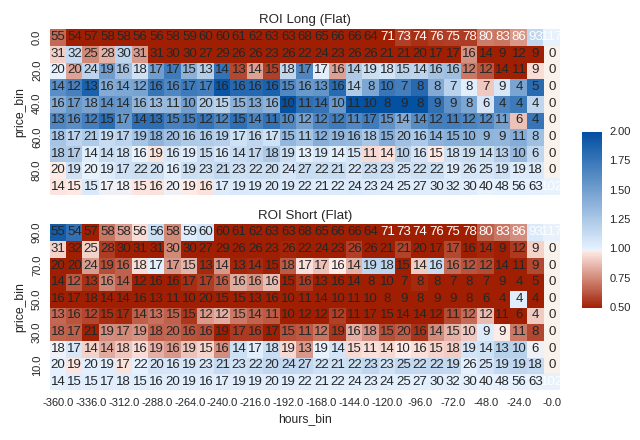

<IPython.core.display.Javascript object>


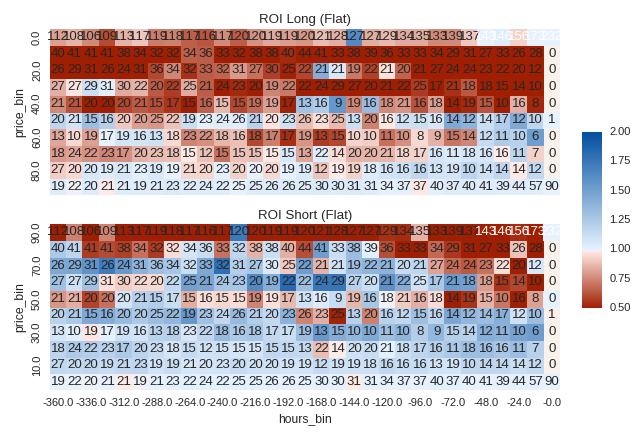

(<matplotlib.axes._subplots.AxesSubplot at 0x7f82cd94e410>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82b385b350>)

In [190]:
roid, roir = map(trades_to_tproi, (ptradesd, ptradesr))
plot_rois(roid, samplesize=True)
plot_rois(roir, samplesize=True)

In [214]:
known = (~trades.result.isnull())
last10dfilter = (trades.countdown > -pd.datetools.timedelta(days=10))
ttrades = trades[known & last10dfilter]
highfilter = (ttrades.trade_price > 90.)
lofilter = (ttrades.trade_price < 10.)
highs = ttrades[highfilter]
lows = ttrades[lofilter]
highcost = (highs.trade_price*highs.trade_quantity).sum()
highreturn = (100*highs.result*highs.trade_quantity).sum()
print highcost, highreturn, highreturn-highcost, highreturn/highcost

lowcost = ((100. - lows.trade_price)*lows.trade_quantity).sum()
lowreturn = (100*(lows.result==0)*lows.trade_quantity).sum()
print lowcost, lowreturn, lowreturn-lowcost, lowreturn/lowcost

102610246.5 104577300.0 1967053.5 1.01917014691
300616918.9 304833900 4216981.1 1.01402775704


In [12]:
knowntrades = trades[~(trades.result.isnull())]

In [13]:
def get_ledger(trades, rule, style='long'):
    cols = ['trade_price', 'trade_quantity', 'result', 'datetime_utc', 'final_time']
    purchases = trades.loc[rule, cols]
    if style=='long':
        purchases['cost'] = -purchases.trade_price*purchases.trade_quantity
        purchases['payout'] = (100. * purchases.result)*purchases.trade_quantity
        payouts = purchases[purchases.result==1].groupby('final_time').payout.sum()
    else:
        purchases['cost'] = -(100. - purchases.trade_price)*purchases.trade_quantity
        purchases['payout'] = (100. * (purchases.result==0))*purchases.trade_quantity
        payouts = purchases[purchases.result==0].groupby('final_time').payout.sum()
    ledger = pd.concat([payouts, purchases.cost]).sort_index().copy()
    return ledger, purchases
    
        
def trade_strategy(trades, rule, style='long'):
    ledger, purchases = get_ledger(trades, rule, style)
    return ledger

In [14]:
ledgers = dict()
purchases = dict()
sledgers = dict()
spurchases = dict()

for p in xrange(99, 49, -1):
    ledgers[p] = {}
    purchases[p] = {}
    sledgers[p] = {}
    spurchases[p] = {}
    pfilter = (knowntrades.trade_price >= p) & (knowntrades.trade_price < (p+1))
    spfilter = (knowntrades.trade_price >= (99-p)) & (knowntrades.trade_price < (100-p))
    for d in xrange(1, 21):
        print '.',
        tfilter = (knowntrades.countdown >= -pd.datetools.timedelta(days=d)) & \
                  (knowntrades.countdown <  -pd.datetools.timedelta(days=(d-1)))
        ledger, purchase = get_ledger(knowntrades, (tfilter & pfilter))
        ledgers[p][d] = ledger
        purchases[p][d] = purchase
        sledger, spurchase = get_ledger(knowntrades, (tfilter & spfilter), 'short')
        sledgers[p][d] = sledger
        spurchases[p][d] = spurchase

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [15]:
price = []
day = []
outcome = []
lowpoint = []
for p, days in ledgers.iteritems():
    for d, l in days.iteritems():
        price.append(p)
        day.append(d)
        outcome.append(l.sum())
        lowpoint.append(l.cumsum().min())
strat_outcomes = pd.DataFrame({
        'daysout': [-d for d in day],
        'pricerange': price,
        'outcome': outcome,
        'lowpoint': lowpoint
    })
strat_heatmap = strat_outcomes.pivot(index='pricerange', columns='daysout', values='outcome')
strat_heatmap.sort_index(inplace=True, ascending=False)

<IPython.core.display.Javascript object>


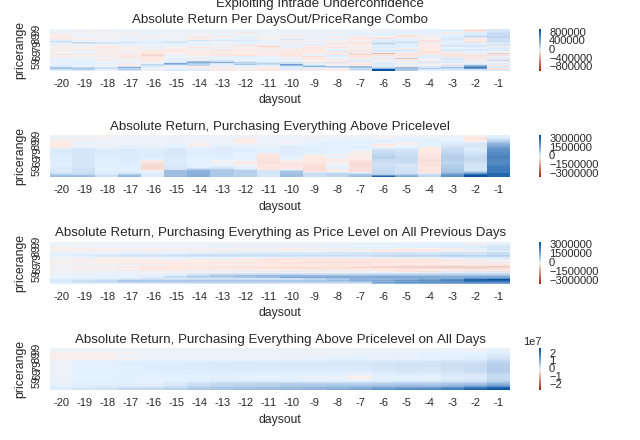

In [29]:
%matplotlib notebook
hmargs = {'yticklabels': 10, 'cmap': cmap}
f, axes = plt.subplots(4,1, sharex=False, sharey=True)
sns.heatmap(strat_heatmap, ax=axes[0], **hmargs)
axes[0].set_title('Absolute Return Per DaysOut/PriceRange Combo')
sns.heatmap(strat_heatmap.cumsum(), ax=axes[1], **hmargs)
axes[1].set_title('Absolute Return, Purchasing Everything Above Pricelevel')
sns.heatmap(strat_heatmap.cumsum(axis=1), ax=axes[2], **hmargs)
axes[2].set_title('Absolute Return, Purchasing Everything as Price Level on All Previous Days')
sns.heatmap(strat_heatmap.cumsum().cumsum(axis=1), ax=axes[3], **hmargs)
axes[3].set_title('Absolute Return, Purchasing Everything Above Pricelevel on All Days')
f.text(0.5, 0.99, 'Exploiting Intrade Underconfidence', ha='center', va='center')
f.tight_layout()

In [27]:
flatledgers = pd.DataFrame()
for lrow in ledgers.itervalues():
    for l in lrow.itervalues():
        flatledgers = pd.concat((flatledgers, l))
flatledgers.sort_index(inplace=True)
flatledgers.rename(columns={0: 'balance'}, inplace=True)

<IPython.core.display.Javascript object>


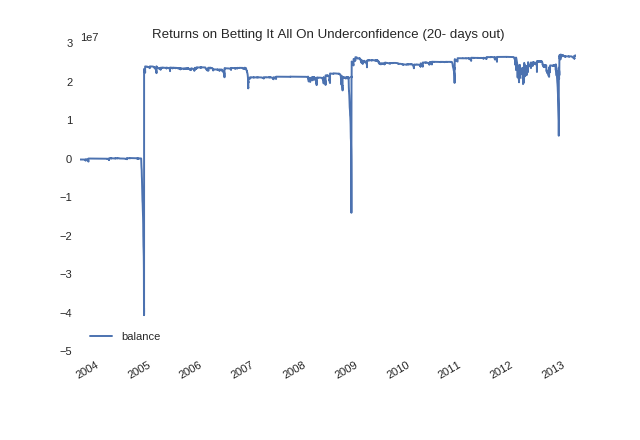

In [75]:
%matplotlib notebook
ax = plt.gca()
flatledgers.cumsum().plot(label='cash on hand', ax=ax)
ax.set_title('Returns on Betting It All On Underconfidence (20- days out)')
